# Импорты

In [167]:
import pandas as pd
import numpy as np
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
import plotly.io as pio
from sklearn.preprocessing import LabelEncoder
from category_encoders import TargetEncoder
from matplotlib.pyplot import rcParams
import warnings
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import r2_score
import shap

# Глобальные настройки

In [96]:
%matplotlib inline
rcParams['figure.figsize'] = 16, 8

pio.templates.default = 'seaborn'

warnings.filterwarnings('ignore')

# Чтение данных

In [97]:
df = pd.read_csv('car_price_prediction.csv')

# Ревью

In [98]:
df.head()

ID  Price  Levy Manufacturer    Model  Prod. year   Category  \
0  45654403  13328  1399        LEXUS   RX 450        2010       Jeep   
1  44731507  16621  1018    CHEVROLET  Equinox        2011       Jeep   
2  45774419   8467     -        HONDA      FIT        2006  Hatchback   
3  45769185   3607   862         FORD   Escape        2011       Jeep   
4  45809263  11726   446        HONDA      FIT        2014  Hatchback   

  Leather interior Fuel type Engine volume    Mileage  Cylinders  \
0              Yes    Hybrid           3.5  186005 km        6.0   
1               No    Petrol             3  192000 km        6.0   
2               No    Petrol           1.3  200000 km        4.0   
3              Yes    Hybrid           2.5  168966 km        4.0   
4              Yes    Petrol           1.3   91901 km        4.0   

  Gear box type Drive wheels   Doors             Wheel   Color  Airbags  
0     Automatic          4x4  04-May        Left wheel  Silver       12  
1     Tiptronic          4x4  04-May        Left wheel   Black        8  
2      Variator        Front  04-May  Right-hand drive   Black        2  
3     Automatic          4x4  04-May        Left wheel   White        0  
4     Automatic        Front  04-May        Left wheel  Silver        4

In [99]:
n_rows, n_cols = df.shape

f'В датасете {n_rows} записей и {n_cols} признаков'

'В датасете 19237 записей и 18 признаков'

In [100]:
df.dtypes

ID                    int64
Price                 int64
Levy                 object
Manufacturer         object
Model                object
Prod. year            int64
Category             object
Leather interior     object
Fuel type            object
Engine volume        object
Mileage              object
Cylinders           float64
Gear box type        object
Drive wheels         object
Doors                object
Wheel                object
Color                object
Airbags               int64
dtype: object

В датасете подавляющее большинство категориальных призанков, хотя, например, `Levy` (налог) или `Mileage` (пробег) должен быть дискртеным

In [101]:
df.isnull().sum()

ID                  0
Price               0
Levy                0
Manufacturer        0
Model               0
Prod. year          0
Category            0
Leather interior    0
Fuel type           0
Engine volume       0
Mileage             0
Cylinders           0
Gear box type       0
Drive wheels        0
Doors               0
Wheel               0
Color               0
Airbags             0
dtype: int64

Пропущенных значений в датасете не наблюдается

In [102]:
df.describe().T

count          mean            std         min         25%  \
ID          19237.0  4.557654e+07  936591.422799  20746880.0  45698374.0   
Price       19237.0  1.855593e+04  190581.269684         1.0      5331.0   
Prod. year  19237.0  2.010913e+03       5.668673      1939.0      2009.0   
Cylinders   19237.0  4.582991e+00       1.199933         1.0         4.0   
Airbags     19237.0  6.582627e+00       4.320168         0.0         4.0   

                   50%         75%         max  
ID          45772308.0  45802036.0  45816654.0  
Price          13172.0     22075.0  26307500.0  
Prod. year      2012.0      2015.0      2020.0  
Cylinders          4.0         4.0        16.0  
Airbags            6.0        12.0        16.0

# Препроцессинг

В описании датасета было сказано, что в данных есть диблирующие записи, проверим

In [103]:
prev_shape = df.shape
df = df.drop_duplicates(keep=False)
new_shape = df.shape

prev_shape, new_shape

((19237, 18), (18704, 18))

In [104]:
f'Действительно, в датасете было {prev_shape[0] - new_shape[0]} дубликатов, они было удалены'

'Действительно, в датасете было 533 дубликатов, они было удалены'

## Levy

In [105]:
len(df[df['Levy'] == '-'])

5651

In [106]:
len(df[df['Levy'] == '0'])

0

Заменим `-` на `0` и приведём к инту

In [107]:
df.Levy = df.Levy.apply(lambda x : str(x).replace("-","0"))
df.Levy = df.Levy.apply(int)
df.Levy.dtype

dtype('int64')

## Mileage

In [108]:
len(df[df['Mileage'].str.contains(r'([a-z])')])

18704

Очистим призанак от постфикса и приведём к дискретной величине

In [109]:
df.Mileage = df.Mileage.apply(lambda x : str(x).replace("km"," "))
df.Mileage = df.Mileage.apply(int)
df.Mileage.dtype

dtype('int64')

## Doors

In [110]:
df.Doors.value_counts()

04-May    17822
02-Mar      759
>5          123
Name: Doors, dtype: int64

Предаполагаю, что должно быть `2-3` и `4-5` вместо `02-Mar` и `04-May` соответственно

In [111]:
df.Doors = df.Doors.apply(lambda x : str(x).replace("04-May","4-5"))
df.Doors = df.Doors.apply(lambda x : str(x).replace("02-Mar","2-3"))

df.Doors.value_counts()

4-5    17822
2-3      759
>5       123
Name: Doors, dtype: int64

### Engine volume

Признак должен быть дискретным, стоит перенести приставку `Turbo` (турбированный мотор) в отдельную булевую фичу

In [112]:
df['Turbo'] = df['Engine volume'].str.strip().apply(lambda x : 1 if len(x) > 3 else 0)

In [113]:
df['Engine volume'] = df['Engine volume'].str.replace(r'([a-z,' ',A-Z])','').astype('f')

Уберём пороговые значения для лучшего качества модели

In [114]:
q1 = df.quantile(0.1)
q3 = df.quantile(0.9)
iqr = q3-q1
len(df[((df>q3+3*iqr) | (df<q1-3*iqr)).any(axis=1)])

746

In [1]:
df = df[~(((df>q3+3*iqr) | (df<q1-3*iqr)).any(axis=1))]

NameError: name 'df' is not defined

In [116]:
df.shape

(17958, 19)

In [117]:
df = df.drop('ID', axis=1)

# EDA

## Дискретные признаки

In [118]:
num_col = list(df.select_dtypes(np.number).columns)
num_col

['Price',
 'Levy',
 'Prod. year',
 'Engine volume',
 'Mileage',
 'Cylinders',
 'Airbags',
 'Turbo']

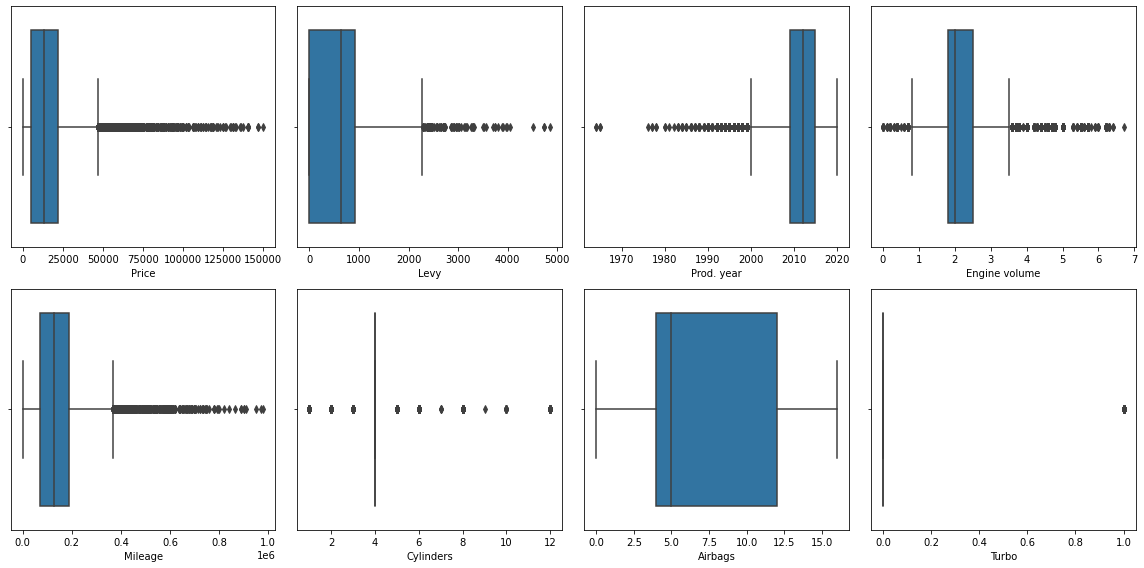

In [119]:
plt.figure(figsize=[16,8])
for i,j in enumerate(num_col):
    plt.subplot(2,4,i+1)
    sns.boxplot(df[j])
    plt.tight_layout()
plt.show()

### Cylinders

<AxesSubplot:xlabel='Cylinders', ylabel='count'>

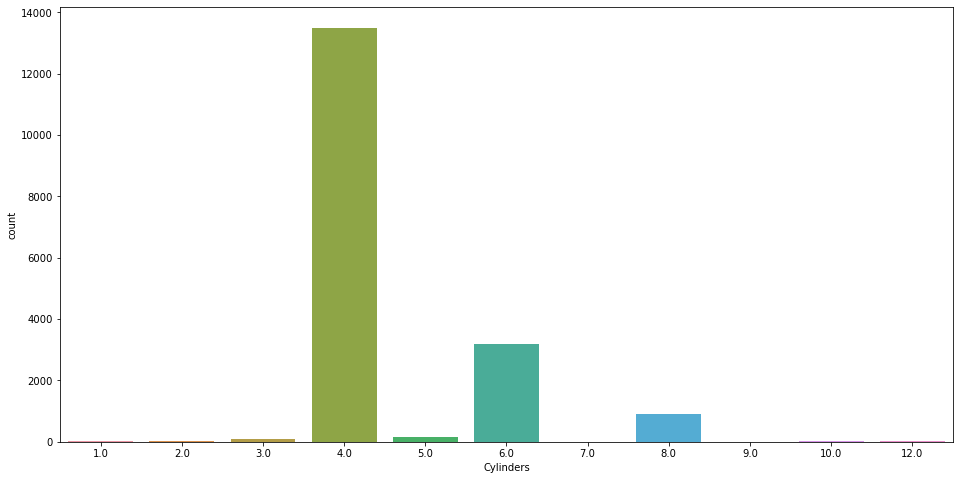

In [120]:
sns.countplot(x="Cylinders", data=df)

Машины преимущественно 4-х и 6-ти цилиндровые

### Prod. year

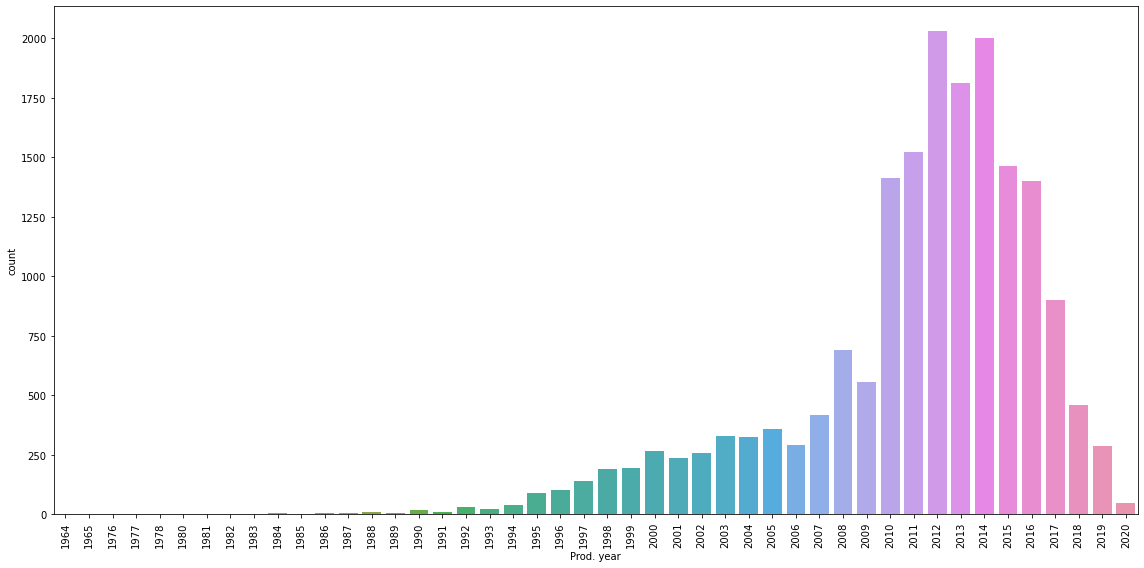

In [121]:
plt.figure(figsize=[16,8])
sns.countplot(x="Prod. year", data=df)
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

### Mileage

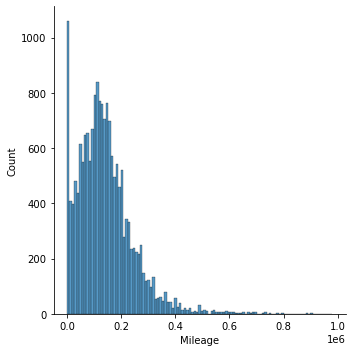

In [122]:
sns.displot(data=df, x="Mileage")

Большинство машин "с салона" - без пробега

## Категориальные признаки

### Fuel type

In [123]:
fuel_type_counts = df['Fuel type'].value_counts()
fuel_type_df = pd.DataFrame({'names': fuel_type_counts.index, 'values': fuel_type_counts.values})
fuel_type_df

names  values
0          Petrol    9376
1          Diesel    3857
2          Hybrid    3345
3             LPG     860
4             CNG     440
5  Plug-in Hybrid      79
6        Hydrogen       1

In [124]:
fig = px.pie(fuel_type_df, values='values', names='names', title='Распределение по типу двигателя')
fig.show()

Большинство машин бензиновые и дизельные

### Gear box type

In [125]:
gear_box_type_counts = df['Gear box type'].value_counts()
gear_box_type_df = pd.DataFrame({'names': gear_box_type_counts.index, 'values': gear_box_type_counts.values})
gear_box_type_df

names  values
0  Automatic   12748
1  Tiptronic    2831
2     Manual    1698
3   Variator     681

In [126]:
fig = px.pie(gear_box_type_df, values='values', names='names', title='Распределение по типу КПП')
fig.show()

### Целевая переменная

Теперь посмоитрим на признаки в разрезе целевой переменной (цены)

In [127]:
cat_col = list(df.select_dtypes('O').columns)
cat_col

['Manufacturer',
 'Model',
 'Category',
 'Leather interior',
 'Fuel type',
 'Gear box type',
 'Drive wheels',
 'Doors',
 'Wheel',
 'Color']

In [128]:
for i in df:
    if len(df[i].unique())<25:
        boxxx = px.box(data_frame=df,x=i,y='Price')
        boxxx.show()

In [129]:
fig = px.scatter(df, x="Mileage", y="Price")
fig.show()

Ожидаемо, с увеличением пробега, цена падает

In [130]:
fig = px.scatter(df, x="Prod. year", y="Price", color="Leather interior")
fig.show()

Цена выше на новые автомобили с кожанным салоном. Есть исключения, скорее всего это редкие ретро-автомобили

<AxesSubplot:>

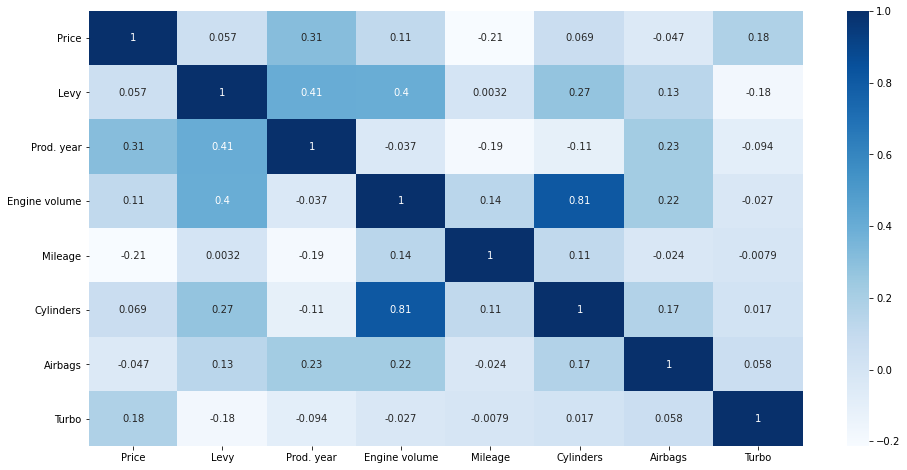

In [131]:
sns.heatmap(data=df.corr(), cmap='Blues', annot=True)

Признаки `Engine volume` и `Cylinders` - мультиколлинеарны, лучше объединить их в один

In [132]:
fig = px.treemap(data_frame=df, path=["Manufacturer","Category","Model"],title='Распределение по производителю, типу кузова и моделям')
fig.show()

# Формирование фичей

Мы уже сформировали одну новую фичу, которая, как показал разведывательный анализ данных, положительно влияет на целевую переменную - `Turbo` (наличие турбированного мотора)

In [133]:
df.Turbo.value_counts()

0    16247
1     1711
Name: Turbo, dtype: int64

In [134]:
df.drop('Cylinders', axis=1, inplace=True)

# Кодирование признаков

In [135]:
df_encoded = df.copy()

In [136]:
df_encoded['Leather interior'] = df_encoded['Leather interior'].map({'Yes': 1, 'No': 0})

In [137]:
# Признаки, которые нам нужно закодировать различными способами
cat_col = list(df_encoded.select_dtypes('O').columns)
cat_col

['Manufacturer',
 'Model',
 'Category',
 'Fuel type',
 'Gear box type',
 'Drive wheels',
 'Doors',
 'Wheel',
 'Color']

Признаки `Model` и `Category` будем кодировать с помощью Target encoding, `Wheel` - с помощью Binary Ohe hot encoding (`Left wheel` в противном случае `Right-hand drive`), `Color`, `Manufacturer` - с помощью Label encoding, остальные с помощью One hot encoding

1. Binary One-hot encoding
- `Wheel`
2. One-hot encoding
- `Fuel type`
- `Gear box type`
- `Drive wheels`
- `Doors`
3. Label encoding
- `Manufacturer`
- `Color`
4. Target encoding
- `Model`
- `Category`

## Wheel

In [138]:
df_encoded['Left_wheel'] = df_encoded['Wheel'].map({'Left wheel': 1, 'Right-hand drive': 0})
df_encoded['Left_wheel'].value_counts()

1    16693
0     1265
Name: Left_wheel, dtype: int64

## Fuel type, Gear box type, Drive wheels, Doors

In [139]:
def one_hot_encoder(data,feature,keep_first=True):

    one_hot_cols = pd.get_dummies(data[feature])
    
    for col in one_hot_cols.columns:
        one_hot_cols.rename({col:f'{feature}_'+col},axis=1,inplace=True)
    
    new_data = pd.concat([data,one_hot_cols],axis=1)
    new_data.drop(feature,axis=1,inplace=True)
    
    if keep_first == False:
        new_data=new_data.iloc[:,1:]
    
    return new_data

In [140]:
one_hot_encoded_columns = ['Fuel type', 'Gear box type', 'Drive wheels', 'Doors']

In [141]:
for col in one_hot_encoded_columns:
    df_encoded = one_hot_encoder(df_encoded, col)

In [142]:
df_encoded.columns

Index(['Price', 'Levy', 'Manufacturer', 'Model', 'Prod. year', 'Category',
       'Leather interior', 'Engine volume', 'Mileage', 'Wheel', 'Color',
       'Airbags', 'Turbo', 'Left_wheel', 'Fuel type_CNG', 'Fuel type_Diesel',
       'Fuel type_Hybrid', 'Fuel type_Hydrogen', 'Fuel type_LPG',
       'Fuel type_Petrol', 'Fuel type_Plug-in Hybrid',
       'Gear box type_Automatic', 'Gear box type_Manual',
       'Gear box type_Tiptronic', 'Gear box type_Variator', 'Drive wheels_4x4',
       'Drive wheels_Front', 'Drive wheels_Rear', 'Doors_2-3', 'Doors_4-5',
       'Doors_>5'],
      dtype='object')

## Manufactrer, Color

In [143]:
label_encoded_columns = ['Manufacturer', 'Color']

In [144]:
le = LabelEncoder()

for col in label_encoded_columns:
    df_encoded[col]=le.fit_transform(df_encoded[col])

In [145]:
df_encoded[['Manufacturer', 'Color']].head()

Manufacturer  Color
0            29     12
2            19      1
3            14     14
4            19     12
5            21     14

## Model, Category

In [146]:
target_encoded_columns = ['Model', 'Category']

In [147]:
for col in target_encoded_columns:
    te=TargetEncoder()
    df_encoded[col] = te.fit_transform(df_encoded[col], df_encoded.Price)

In [148]:
df_encoded = df_encoded.drop('Wheel', axis=1)
df_encoded.head()

Price  Levy  Manufacturer         Model  Prod. year      Category  \
0  13328  1399            29  10374.423529        2010  23038.605156   
2   8467     0            19  11968.864322        2006  11417.001164   
3   3607   862            14   8001.776978        2011  23038.605156   
4  11726   446            19  11968.864322        2014  11417.001164   
5  39493   891            21  39559.144509        2016  23038.605156   

   Leather interior  Engine volume  Mileage  Color  ...  \
0                 1            3.5   186005     12  ...   
2                 0            1.3   200000      1  ...   
3                 1            2.5   168966     14  ...   
4                 1            1.3    91901     12  ...   
5                 1            2.0   160931     14  ...   

   Gear box type_Automatic  Gear box type_Manual  Gear box type_Tiptronic  \
0                        1                     0                        0   
2                        0                     0                        0   
3                        1                     0                        0   
4                        1                     0                        0   
5                        1                     0                        0   

   Gear box type_Variator  Drive wheels_4x4  Drive wheels_Front  \
0                       0                 1                   0   
2                       1                 0                   1   
3                       0                 1                   0   
4                       0                 0                   1   
5                       0                 0                   1   

   Drive wheels_Rear  Doors_2-3  Doors_4-5  Doors_>5  
0                  0          0          1         0  
2                  0          0          1         0  
3                  0          0          1         0  
4                  0          0          1         0  
5                  0          0          1         0  

[5 rows x 30 columns]

# Разбиение данных

In [149]:
X = df_encoded.copy()
X.drop('Price', axis=1, inplace=True)
y = df_encoded['Price']

In [150]:
X_train , X_test , y_train , y_test = train_test_split(X, y, random_state=100, test_size=0.3)

# Базовая модель

In [151]:
base_XGB = XGBRegressor(n_estimators=100, booster='gbtree', random_state=100)

In [152]:
base_XGB.fit(X_train ,y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=8, num_parallel_tree=1, random_state=100,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [153]:
y_train_pred_base_XGB = base_XGB.predict(X_train)
y_test_pred_base_XGB = base_XGB.predict(X_test)

In [154]:
Train_rsquare_base_XGB = r2_score(y_train,y_train_pred_base_XGB)
print("Train R-square: ", Train_rsquare_base_XGB,'\n')

Test_rsquare_base_XGB = r2_score(y_test , y_test_pred_base_XGB)
print("Test R-square: ", Test_rsquare_base_XGB,'\n')

Train R-square:  0.9270987354063265 

Test R-square:  0.7854591929866865 



Кажется, имеет место переобучение - разница на трейне и тесте слишком велика.

# Кросс-валидация

In [155]:
crossval_scores_base_XGB = cross_val_score(base_XGB, X_test, y_test, cv=15, scoring='r2')
print('Test Scores:',crossval_scores_base_XGB)

print(f'Score Mean: {crossval_scores_base_XGB.mean()} +- {crossval_scores_base_XGB.std()}')

Test Scores: [0.71041124 0.63347817 0.76172191 0.77091086 0.74082859 0.77453409
 0.72776313 0.80750325 0.65527716 0.77056757 0.73839209 0.75728026
 0.65645829 0.72103487 0.72277554]
Score Mean: 0.7299291335204817 +- 0.04766354846095239


# Бустинг гиперпараметров

In [156]:
learning_rates = [0.5, 0.1, 0.05]
n_estimators = [100, 250, 500]
max_depths = [2, 4, 6]
boosters = ['gbtree']

param_grid = {
    'n_estimators': n_estimators,
    'learning_rate': learning_rates,
    'max_depth': max_depths,
    'booster': boosters
}

In [157]:
estimator = XGBRegressor(random_state=100, n_jobs=-1)

In [158]:
grid = GridSearchCV(estimator=estimator, 
                   param_grid=param_grid,
                   scoring='r2',
                   cv=5, 
                   n_jobs=-1)

grid.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, gamma=None,
                                    gpu_id=None, importance_type='gain',
                                    interaction_constraints=None,
                                    learning_rate=None, max_delta_step=None,
                                    max_depth=None, min_child_weight=None,
                                    missing=nan, monotone_constraints=None,
                                    n_estimators=100, n_jobs=-1,
                                    num_parallel_tree=None, random_state=100,
                                    reg_alpha=None, reg_lambda=None,
                                    scale_pos_weight=None, subsample=None,
                                    tree_method=None, validate_parameters=None,
                                    verbosity=None),
             n_jobs=-1,
             param_grid={'booster': ['gbtree'],
                         'learning_rate': [0.5, 0.1, 0.05],
                         'max_depth': [2, 4, 6],
                         'n_estimators': [100, 250, 500]},
             scoring='r2')

In [159]:
print(grid.best_score_)
print(grid.best_params_)

0.7755361200829787
{'booster': 'gbtree', 'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 500}


# Итоговая модель

In [160]:
tuned_XGB = XGBRegressor(random_state=100, **grid.best_params_)

In [161]:
tuned_XGB.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.1, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=500, n_jobs=8, num_parallel_tree=1, random_state=100,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [164]:
y_test_pred_tuned_XGB = tuned_XGB.predict(X_test)

In [165]:
Test_rsquare_base_XGB = r2_score(y_test , y_test_pred_tuned_XGB)
print("Test R-square: ", Test_rsquare_base_XGB,'\n')

Test R-square:  0.7966008212750386 



# Интерпретация результатов

In [168]:
explainer = shap.TreeExplainer(tuned_XGB)
shap_values = explainer.shap_values(X_test)

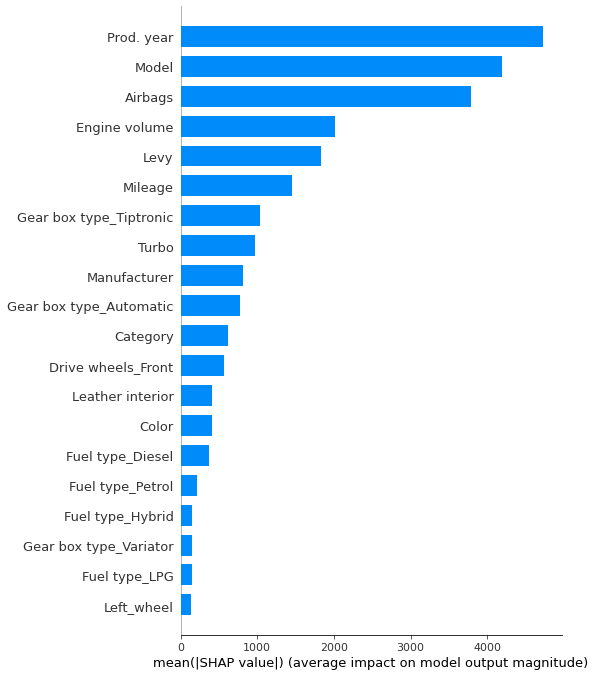

In [169]:
shap.initjs()
shap.summary_plot(shap_values, X_test, plot_type="bar")

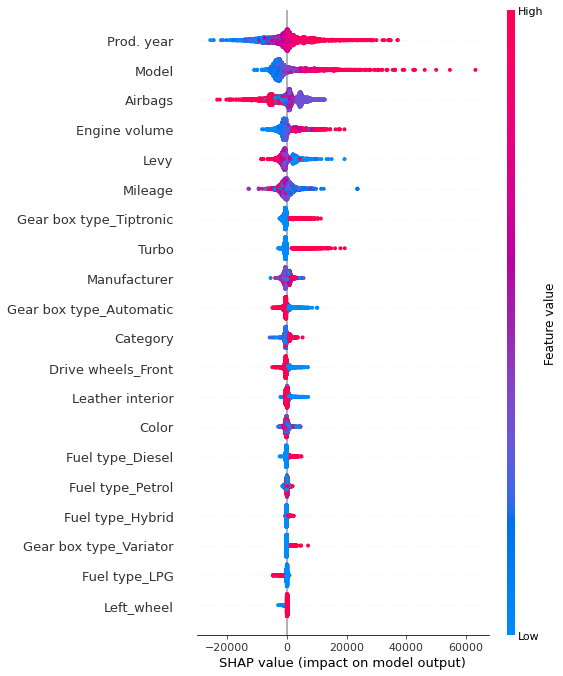

In [170]:
shap.initjs()
shap.summary_plot(shap_values, X_test)

Довольно ожидаемо, `Prod. year` (год эксплуатации) и `Model` (модель автомобиля) оказались самыми важными фичами для предиктора. Неожиданно `Airbags` (количество подушек безопасности), важность которого столь высока. Предполагалось, что `Mileage` (пробег) будет выше. `Engine volume` (объем двигателя) также сильно влияет на таргет. В ццелом важность фич выглядит адекватно.